# CORRECTION OF SELECTION BIAS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model_class_cb import CatBoostXT_BAG
from model_class_lgbm import LightGBMXT_BAG

In [333]:
from model_utils import *

In [4]:
from other_utils import compare_distributions

In [5]:
from ipw import compute_ipw_weights, effective_sample_size

In [6]:
from self_learning_orchestrator import SelfLearningConfig, SelfLearningOrchestrator

In [692]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import pickle
from scipy.special import expit, logit
import optuna
import json
from sklearn.model_selection import train_test_split

In [8]:
data_dir = r'E:\Project\Dissertation'

In [9]:
with open(rf'{data_dir}\models\dict_cols.json') as json_file:
    dict_cols = json.load(json_file)

In [10]:
# separate features, target
list_features = dict_cols['list_features']
# features that starts with EXT_
list_ext_features = dict_cols['list_ext_features']
# list ethical features
list_ethical_features = dict_cols['list_ethical_features']
# list categorical features
list_cat_features = dict_cols['list_cat_features']

In [11]:
list_key = dict_cols['list_key']
label_col = dict_cols['label_col']

## Inverted prospensity weighting (IPW)

### Build Acceptance propensity model

In [12]:
df = pd.read_parquet(rf'{data_dir}\data\processed\master_data_simulated_approval_and_reject.parquet')

In [13]:
label_accept = 'flag_accepted'

In [11]:
df.groupby(['flag_train_val','flag_accepted'])['flag_accepted'].count()

flag_train_val  flag_accepted
train           0                196339
                1                 34294
valid           0                 65442
                1                 11436
Name: flag_accepted, dtype: int64

In [12]:
X_accept_train = df.loc[df['flag_train_val']=='train', list_features]
X_accept_valid = df.loc[df['flag_train_val']=='valid', list_features]

y_accept_train = df.loc[df['flag_train_val']=='train', label_accept]
y_accept_valid = df.loc[df['flag_train_val']=='valid', label_accept]

In [13]:
# Check MNAR assumption: OK if set is empty
set(X_accept_train.columns.to_list()).intersection(set(list_ext_features+['flag_has_bureau']))

set()

In [206]:
accept_model = CatBoostXT_BAG(
    num_bag_folds=1,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [207]:
accept_model.params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 5,
    'l2_leaf_reg': 50,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [49]:
accept_model.fit(X_accept_train, y_accept_train,eval_set=(X_accept_valid, y_accept_valid))

In [50]:
accept_model.evaluate(X_accept_train, y_accept_train)

{'ROC_AUC': 0.8991110507263343, 'PR_AUC': 0.6917703099050095}

In [51]:
accept_model.evaluate(X_accept_valid, y_accept_valid)

{'ROC_AUC': 0.8815137499261219, 'PR_AUC': 0.6812481083066579}

In [176]:
calib_result_summary = accept_model.calibrate(X_accept_valid, y_accept_valid, method='sigmoid')

Brier score: 0.080759 | ECE: 0.074263


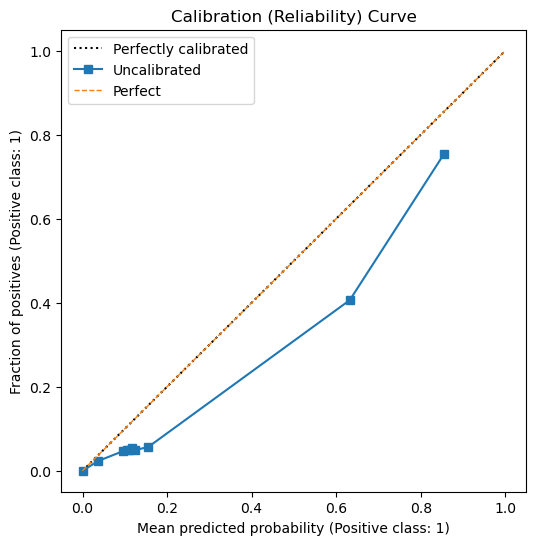

In [177]:
_ = accept_model.plot_calibration_curve(X_accept_valid, y_accept_valid, n_bins=10, strategy="quantile", use_calibrated=False)

Brier score: 0.072033 | ECE: 0.010317


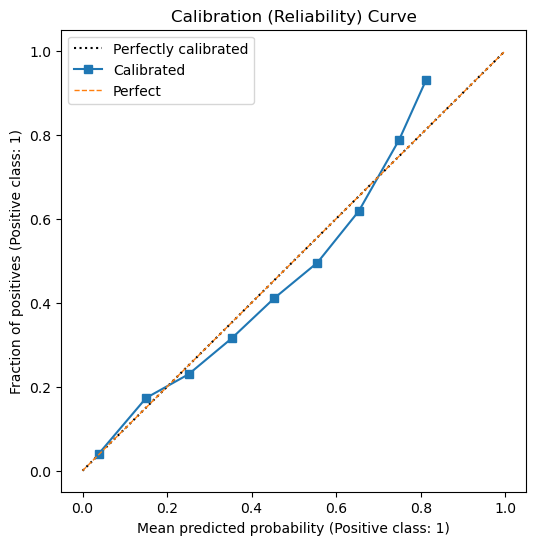

In [178]:
tbl = accept_model.plot_calibration_curve(X_accept_valid, y_accept_valid, n_bins=10, strategy="uniform",
                                   use_calibrated=True, return_table=True)

In [179]:
with open(rf'{data_dir}\models\accept_propensity_model_cb.pkl', 'wb') as f:
    pickle.dump(accept_model, f)

In [208]:
# load model
with open(rf'{data_dir}\models\accept_propensity_model_cb.pkl', 'rb') as f:
    accept_model = pickle.load(f)

### Improve base model with IPW

In [181]:
acc_mask = (df["flag_accepted"].values == 1)

In [182]:
df["flag_accepted"].value_counts()

flag_accepted
0    261781
1     45730
Name: count, dtype: int64

In [183]:
p_accept=accept_model.predict_proba_calib(df[list_features])[:,1]

In [184]:
p_accept[acc_mask]

array([0.04004417, 0.78150897, 0.72601455, ..., 0.04189581, 0.39557786,
       0.68154189])

In [185]:
w_all = np.sqrt(compute_ipw_weights(
    accept=df["flag_accepted"].values,
    p_accept=p_accept,
    stabilize=False, trim_quantiles=(0.05, 0.95), cap_max=10
))
print("Train ESS (accepted only):", effective_sample_size(w_all[acc_mask]))

Train ESS (accepted only): 37296.99845468228


In [186]:
w_all[acc_mask]

array([3.16227766, 1.13118338, 1.17361955, ..., 3.16227766, 1.589952  ,
       1.21130559])

In [187]:
train_mask = (df['flag_train_val']=='train')

In [188]:
X_train = df.loc[acc_mask & train_mask, list_features]
y_train = df.loc[acc_mask & train_mask, label_col].values
w_train = w_all[acc_mask & train_mask]

In [189]:
X_val = df.loc[acc_mask & ~train_mask, list_features]
y_val = df.loc[acc_mask & ~train_mask, label_col].values
w_val = w_all[acc_mask & ~train_mask]

In [190]:
len(y_train), len(y_val)

(34294, 11436)

#### Tunning

In [113]:
study_enhanced_ipw = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2025-09-21 23:53:01,162] A new study created in memory with name: no-name-da8d3968-f98e-41ca-a034-ce5ba405d883


In [117]:
def objective(trial):
    param = {
        'iterations': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 5),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 100),
        'border_count': 128,
        'auto_class_weights': 'SqrtBalanced',
        'early_stopping_rounds': None,
        'od_type': 'IncToDec',
        'od_wait': 200,
        'od_pval': 0.01,
        'boosting_type': 'Ordered',
        'bootstrap_type': 'Bernoulli',
        'loss_function': 'Logloss', 
        'eval_metric': 'Logloss',
        'task_type':'GPU',
        'devices':'0',
    }
    
    model = CatBoostXT_BAG(
        num_bag_folds=1,
        num_bag_repeats=1,
        random_state=1,
        cat_features=list_cat_features
        )
    model.params = param
    model.fit(X_train, y_train, weights=w_train, eval_set=(X_val, y_val), eval_set_weights=w_val)
    
    #train_pred = model.predict_proba(X_train)[:,1]
    val_pred = model.predict_proba(X_val)[:,1]
    #train_metric = f_roc_auc(y_train, train_pred)
    val_metric = f_roc_auc(y_val, val_pred)
    
    return val_metric #- 1*abs(val_metric - train_metric)

In [118]:
study_enhanced_ipw.optimize(objective, n_trials=100)

[I 2025-09-21 23:58:13,459] Trial 1 finished with value: 0.6986124986124986 and parameters: {'learning_rate': 0.014263071185663497, 'depth': 3, 'l2_leaf_reg': 26}. Best is trial 1 with value: 0.6986124986124986.
[I 2025-09-21 23:58:58,853] Trial 2 finished with value: 0.6931977113795296 and parameters: {'learning_rate': 0.0814537586347737, 'depth': 4, 'l2_leaf_reg': 91}. Best is trial 1 with value: 0.6986124986124986.
[I 2025-09-22 00:01:29,484] Trial 3 finished with value: 0.7013757286484559 and parameters: {'learning_rate': 0.012355003629410742, 'depth': 3, 'l2_leaf_reg': 10}. Best is trial 3 with value: 0.7013757286484559.
[I 2025-09-22 00:02:29,085] Trial 4 finished with value: 0.6980955071864162 and parameters: {'learning_rate': 0.03960723228000903, 'depth': 5, 'l2_leaf_reg': 93}. Best is trial 3 with value: 0.7013757286484559.
[I 2025-09-22 00:04:14,344] Trial 5 finished with value: 0.6988514852151215 and parameters: {'learning_rate': 0.015876978104643964, 'depth': 3, 'l2_leaf_re

In [119]:
with open(rf'{data_dir}\models\enhanced_ipw_model_optuna_study_cb.pkl', 'wb') as f:
    pickle.dump(study_enhanced_ipw, f)

In [120]:
study_enhanced_ipw.best_params

{'learning_rate': 0.02999050557916954, 'depth': 3, 'l2_leaf_reg': 2}

In [41]:
enhanced_model_ipw = base_model = CatBoostXT_BAG(
    num_bag_folds=5,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [42]:
enhanced_model_ipw.params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'depth': 3,
    'l2_leaf_reg': 2,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 50,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [195]:
enhanced_model_ipw.fit(X_train, y_train, weights=w_train, eval_set=(X_val, y_val), eval_set_weights=w_val)

In [199]:
with open(rf'{data_dir}\models\enhanced_ipw_model_cb.pkl', 'wb') as f:
    pickle.dump(enhanced_model_ipw, f)

In [15]:
with open(rf'{data_dir}\models\enhanced_ipw_model_cb.pkl', 'rb') as f:
    enhanced_model_ipw = pickle.load(f)

In [196]:
enhanced_model_ipw.evaluate(X_train, y_train)

{'ROC_AUC': 0.7435319714846718, 'PR_AUC': 0.19335753677291087}

In [197]:
enhanced_model_ipw.evaluate(X_val, y_val)

{'ROC_AUC': 0.7091506136960682, 'PR_AUC': 0.12167001785520692}

In [198]:
enhanced_model_ipw.evaluate(df.loc[df['flag_train_val']=='valid',list_features],df.loc[df['flag_train_val']=='valid',label_col])

{'ROC_AUC': 0.686009577609755, 'PR_AUC': 0.17001479370829212}

## Self-learning

Use enhanced IPW model above as weak learner for assigning proxy label to reject data

Base model is used as weak learner --> assign label on confident prediction --> retrain main_learner
--> main learner as weak learner and repeat the loop

Until no further improvement can be made or user specified iteration --> stop

### Prep data

In [16]:
acc_mask = (df["flag_accepted"].values == 1)
rej_mask = (df["flag_accepted"].values == 0)

In [17]:
train_mask = (df['flag_train_val']=='train')
valid_mask = (df['flag_train_val']=='valid')

In [18]:
p_accept=accept_model.predict_proba_calib(df[list_features])[:,1]

In [19]:
w_all = np.sqrt(compute_ipw_weights(
    accept=df["flag_accepted"].values,
    p_accept=p_accept,
    stabilize=False, trim_quantiles=(0.05, 0.95), cap_max=10
))
print("Train ESS (accepted only):", effective_sample_size(w_all[acc_mask]))

Train ESS (accepted only): 37296.99845468228


In [20]:
# Accepted only
X_a_train = df.loc[acc_mask & train_mask, list_features]
y_a_train = df.loc[acc_mask & train_mask, label_col]
w_a_train = w_all[acc_mask & train_mask]

X_a_val = df.loc[acc_mask & valid_mask, list_features]
y_a_val = df.loc[acc_mask & valid_mask, label_col]
w_a_val = w_all[acc_mask & valid_mask]

In [72]:
X_all_val = df.loc[valid_mask, list_features]
y_all_val = df.loc[valid_mask, label_col]
w_all_val = w_all[valid_mask]

In [21]:
X_a_train.shape

(34294, 576)

In [22]:
X_a_val.shape

(11436, 576)

In [23]:
y_a_val.value_counts(normalize=True)

TARGET
0    0.952256
1    0.047744
Name: proportion, dtype: float64

In [24]:
# Rejected only
X_r = df.loc[rej_mask, list_features]
prospensity_r = accept_model.predict_proba_calib(X_r)[:,1]

In [25]:
X_r.shape

(261781, 576)

#### Choosing weak learner as teacher

The Teacher quality depends on the tail prediction confident tail 4% - 96% for example. Here we evaluate the tail precision confident and determine the tail probability value (3, 4, 5%) of:
1. baseline model. no improvement made. 2 models: Catboost and LightGBMXT_BAG
2. IPW enhanced model above

In [209]:
# load base model catboost
with open(rf'{data_dir}\models\base_model_simulated_catboostxt_bag.pkl', 'rb') as f:
    base_model_cb = pickle.load(f)


In [106]:
# load base model lgbm
with open(rf'{data_dir}\models\base_model_simulated_lgbmxt_bag.pkl', 'rb') as f:
    base_model_lgbm = pickle.load(f)

In [27]:
base_model_cb

In [107]:
p_base_cb_val = base_model_cb.predict_proba(df.loc[valid_mask & acc_mask,list_features])[:,1]
p_base_lgbm_val = base_model_lgbm.predict_proba(df.loc[valid_mask & acc_mask,list_features])[:,1]
p_base_ipw_val = enhanced_model_ipw.predict_proba(df.loc[valid_mask & acc_mask,list_features])[:,1]

In [110]:
prec_pos, prec_neg, n_pos, n_neg, t_pos_abs, t_neg_abs = tail_precision(p_base_cb_val, y_a_val,mode='percentile', hi=0.98, lo=0.1)
print("Base CB model - Positive tail precision:", prec_pos, "N in tail:", n_pos, "Threshold prob:", t_pos_abs)
print("Base CB model - Negative tail precision:", prec_neg, "N in tail:", n_neg, "Threshold prob:", t_neg_abs)

Base CB model - Positive tail precision: 0.22707423580786026 N in tail: 229 Threshold prob: 0.41202408468804536
Base CB model - Negative tail precision: 0.993006993006993 N in tail: 1144 Threshold prob: 0.07134391417074312


In [30]:
prec_pos, prec_neg, n_pos, n_neg, t_pos_abs, t_neg_abs = tail_precision(p_base_lgbm_val, y_a_val,mode='percentile', hi=0.98, lo=0.1)
print("Base LGBM model - Positive tail precision:", prec_pos, "N in tail:", n_pos, "Threshold prob:", t_pos_abs)
print("Base LGBM model - Negative tail precision:", prec_neg, "N in tail:", n_neg, "Threshold prob:", t_neg_abs)

Base LGBM model - Positive tail precision: 0.048034934497816595 N in tail: 229 Threshold prob: 0.12443193664898038
Base LGBM model - Negative tail precision: 0.9764397905759162 N in tail: 1146 Threshold prob: 0.0377378542406074


In [31]:
prec_pos, prec_neg, n_pos, n_neg, t_pos_abs, t_neg_abs = tail_precision(p_base_ipw_val, y_a_val,mode='percentile', hi=0.98, lo=0.1)
print("Base IPW enhanced model - Positive tail precision:", prec_pos, "N in tail:", n_pos, "Threshold prob:", t_pos_abs)
print("Base IPW enhanced model - Negative tail precision:", prec_neg, "N in tail:", n_neg, "Threshold prob:", t_neg_abs)

Base IPW enhanced model - Positive tail precision: 0.2096069868995633 N in tail: 229 Threshold prob: 0.365317202523359
Base IPW enhanced model - Negative tail precision: 0.993006993006993 N in tail: 1144 Threshold prob: 0.08715934347994665


Conclusion 1:
- to Use Catboost Base line model.
- LGBM base model although has same AUC, but worse tail precision.
- IPW model lower tail precision than base model

Conclusion 2: for bad label
- To use 98% percentile for soft label assignment as the tail precision is around 4.7 times higher than event rate of validation sample (4.77%).
- 97% percentile is 3.96x higher than event rate

For good label, 10% percentile is good enough with 99.3% precision. --> Need it to be high be cause the event rate for good is high (1-4.77% ~ 93%)

#### Training self learning

##### No propensity

In [48]:
# init main learner
main_learner = CatBoostXT_BAG(
    num_bag_folds=1,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [49]:
main_learner

In [50]:
main_learner.params = {
    'iterations': 1000,
    'learning_rate': 0.010353843378600744,
    'depth': 4,
    'l2_leaf_reg': 89,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0'
    }

In [119]:
cfg = SelfLearningConfig(
    n_rounds=10,
    # Use your custom class as the main learner (student)
    main_learner_factory=lambda: main_learner,
    main_fit_weight_arg="weights",       # CatBoostXT_BAG.fit expects 'weights='
    # (optionally still keep a name/kwargs for fallback when no factory is provided)
    # main_learner_name="logit", # option if no factory then fallback to this
    # main_learner_kwargs=dict(C=0.5, solver="liblinear", max_iter=200, class_weight="balanced"), # option if no factory then fallback to this
    # harvesting & safety
    teacher_thresholds=[(0.99, 0.1)],
    threshold_mode = 'percentile',
    max_add_per_round=5000,
    min_new_per_round=100,
    # weights & calibration
    use_propensity_weight=False,
    cap_ipw=10.0,
    calibrate=None,                # will call CatBoostXT_BAG.calibrate(...) if present
    early_stop_metric="auc",
    early_stop_patience=2,
    random_state=42,
)


In [120]:
orch = SelfLearningOrchestrator(cfg)

In [121]:
orch.fit(
    baseline_teacher=base_model_cb,   # e.g., your existing CatBoost baseline
    X_l=X_a_train, y_l=y_a_train, # Labeled data (accepted only)
    X_u=X_r, propensity_u=prospensity_r, # Unlabeled data (rejected only)
    X_val=X_a_val, y_val=y_a_val, # To build eval set
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


SelfLearningOrchestrator(config=SelfLearningConfig(n_rounds=10, main_learner_name='logit', main_learner_kwargs=None, main_learner_factory=<function <lambda> at 0x000001B8E8EB8820>, main_fit_weight_arg='weights', teacher_thresholds=[(0.99, 0.1)], threshold_mode='percentile', percentile_pairs=None, target_precision_pos=0.92, target_precision_neg=0.92, min_val_support=150, abs_floor_hi=0.9, abs_floor_lo=0.1, max_add_per_round=5000, min_new_per_round=100, use_propensity_weight=False, cap_ipw=10.0, require_agreement_rounds=1, agreement_tol=0.15, confidence_floor=0.1, calibrate=None, early_stop_metric='auc', early_stop_patience=2, random_state=42))

In [122]:
orch.history_

[{'round': 0,
  'added': 5000,
  'cum_added': 5000,
  't_pos': 0.431402371534599,
  't_neg': 0.08055103290642648,
  't_pos_abs': 0.431402371534599,
  't_neg_abs': 0.08055103290642648,
  'auc': 0.7063917563917563,
  'pr_auc': 0.06936965926104388,
  'prec_pos': nan,
  'prec_neg': nan,
  'brier': 0.06483742895734768},
 {'round': 1,
  'added': 5000,
  'cum_added': 5000,
  't_pos': 0.6713294269568263,
  't_neg': 0.058624822721052516,
  't_pos_abs': 0.6713294269568263,
  't_neg_abs': 0.058624822721052516,
  'auc': 0.7017102426193336,
  'pr_auc': 0.06678413399338584,
  'prec_pos': nan,
  'prec_neg': nan,
  'brier': 0.06343230884508114},
 {'round': 2,
  'added': 5000,
  'cum_added': 5000,
  't_pos': 0.8400294449245385,
  't_neg': 0.058538658266549075,
  't_pos_abs': 0.8400294449245385,
  't_neg_abs': 0.058538658266549075,
  'auc': 0.7033560715378897,
  'pr_auc': 0.06837562272759061,
  'prec_pos': nan,
  'prec_neg': nan,
  'brier': 0.056796683417526944}]

In [123]:
df_self_hist = orch.get_history()

In [124]:
df_self_hist

,round,added,cum_added,t_pos,t_neg,t_pos_abs,t_neg_abs,auc,pr_auc,prec_pos,prec_neg,brier
0,0,5000,5000,0.431402,0.080551,0.431402,0.080551,0.706392,0.069370,NaN,NaN,0.064837
1,1,5000,5000,0.671329,0.058625,0.671329,0.058625,0.701710,0.066784,NaN,NaN,0.063432
2,2,5000,5000,0.840029,0.058539,0.840029,0.058539,0.703356,0.068376,NaN,NaN,0.056797


In [125]:
orch.model_.evaluate(X_a_val,y_a_val)

{'ROC_AUC': 0.7033560715378897, 'PR_AUC': 0.11611958914941642}

In [126]:
orch.model_.evaluate(X_all_val,y_all_val)

{'ROC_AUC': 0.6553916091812965, 'PR_AUC': 0.1257141564650738}

In [127]:
base_model_cb.evaluate(X_a_val,y_a_val)

{'ROC_AUC': 0.7136296363569091, 'PR_AUC': 0.1251414665267777}

In [128]:
base_model_cb.evaluate(X_all_val,y_all_val)

{'ROC_AUC': 0.6931296713741353, 'PR_AUC': 0.17903990758155733}

##### Use propensity

In [131]:
cfg2 = SelfLearningConfig(
    n_rounds=10,
    # Use your custom class as the main learner (student)
    main_learner_factory=lambda: main_learner,
    main_fit_weight_arg="weights",       # CatBoostXT_BAG.fit expects 'weights='
    # (optionally still keep a name/kwargs for fallback when no factory is provided)
    # main_learner_name="logit", # option if no factory then fallback to this
    # main_learner_kwargs=dict(C=0.5, solver="liblinear", max_iter=200, class_weight="balanced"), # option if no factory then fallback to this
    # harvesting & safety
    teacher_thresholds=[(0.99, 0.1)],
    threshold_mode = 'percentile',
    max_add_per_round=5000,
    min_new_per_round=100,
    # weights & calibration
    use_propensity_weight=True,
    cap_ipw=10.0,
    calibrate=None,                # will call CatBoostXT_BAG.calibrate(...) if present
    early_stop_metric="auc",
    early_stop_patience=10,
    random_state=42,
)


In [132]:
orch2 = SelfLearningOrchestrator(cfg2)

In [133]:
orch2.fit(
    baseline_teacher=base_model_cb,   # e.g., your existing CatBoost baseline
    X_l=X_a_train, y_l=y_a_train, sample_weight_l=np.ones(len(w_a_train)), # Labeled data (accepted only)
    X_u=X_r, propensity_u=prospensity_r, # Unlabeled data (rejected only)
    X_val=X_a_val, y_val=y_a_val, sample_weight_val=np.ones(len(w_a_val)), # To build eval set
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


SelfLearningOrchestrator(config=SelfLearningConfig(n_rounds=10, main_learner_name='logit', main_learner_kwargs=None, main_learner_factory=<function <lambda> at 0x000001BA0A53A1F0>, main_fit_weight_arg='weights', teacher_thresholds=[(0.99, 0.1)], threshold_mode='percentile', percentile_pairs=None, target_precision_pos=0.92, target_precision_neg=0.92, min_val_support=150, abs_floor_hi=0.9, abs_floor_lo=0.1, max_add_per_round=5000, min_new_per_round=100, use_propensity_weight=True, cap_ipw=10.0, require_agreement_rounds=1, agreement_tol=0.15, confidence_floor=0.1, calibrate=None, early_stop_metric='auc', early_stop_patience=10, random_state=42))

In [134]:
df_self_ipw_hist = orch2.get_history()

In [137]:
df_self_ipw_hist

,round,added,cum_added,t_pos,t_neg,t_pos_abs,t_neg_abs,auc,pr_auc,prec_pos,prec_neg,brier
0,0,5000,5000,0.431402,0.080551,0.431402,0.080551,0.697154,0.064696,NaN,NaN,0.071244
1,1,5000,5000,0.841393,0.019130,0.841393,0.019130,0.686511,0.057761,NaN,NaN,0.067514
2,2,5000,5000,0.881818,0.019261,0.881818,0.019261,0.693333,0.058192,NaN,NaN,0.061553
3,3,5000,5000,0.954818,0.016327,0.954818,0.016327,0.691702,0.059261,NaN,NaN,0.052731
4,4,5000,5000,0.997049,0.018413,0.997049,0.018413,0.698279,0.072186,NaN,NaN,0.046054
5,5,5000,5000,0.999091,0.017150,0.999091,0.017150,0.699251,0.075474,NaN,NaN,0.045912
6,6,5000,5000,0.999392,0.024213,0.999392,0.024213,0.701201,0.075492,NaN,NaN,0.045833
7,7,5000,5000,0.999500,0.009576,0.999500,0.009576,0.701802,0.075309,NaN,NaN,0.045850
8,8,5000,5000,0.999460,0.010132,0.999460,0.010132,0.702399,0.075336,NaN,NaN,0.045824
9,9,5000,5000,0.999384,0.008844,0.999384,0.008844,0.701815,0.074810,NaN,NaN,0.045834


In [135]:
orch2.model_.evaluate(X_a_val,y_a_val)

{'ROC_AUC': 0.7018148518148518, 'PR_AUC': 0.12255438548348375}

In [136]:
orch2.model_.evaluate(X_all_val,y_all_val)

{'ROC_AUC': 0.660674198200475, 'PR_AUC': 0.12736983287177633}

In [55]:
[{'round': 0,
  'added': 5000,
  't_pos': 0.98,
  't_neg': 0.1,
  'auc': 0.7040378437240897,
  'brier': 0.07762236036896161},
 {'round': 1,
  'added': 5000,
  't_pos': 0.98,
  't_neg': 0.1,
  'auc': 0.6990558359448451,
  'brier': 0.07825916249365791}]

[{'round': 0,
  'added': 5000,
  't_pos': 0.98,
  't_neg': 0.1,
  'auc': 0.7040378437240897,
  'brier': 0.07762236036896161},
 {'round': 1,
  'added': 5000,
  't_pos': 0.98,
  't_neg': 0.1,
  'auc': 0.6990558359448451,
  'brier': 0.07825916249365791}]

### Guided reject inference

Buying data for true label can be costly, the solution is to select sample that might yield high improvement to the model when perform reject inference

In [148]:
from guided_reject_inference import guided_select, random_select

In [145]:
len(X_r)

261781

In [173]:
X_r = df.loc[rej_mask, list_features].reset_index(drop=True)
y_r = df.loc[rej_mask, label_col].reset_index(drop=True)

In [327]:
pd_reject = base_model_cb.predict_proba(X_r)[:,1]
pi_accept = accept_model.predict_proba_calib(X_r)[:,1]

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Average Probability by Decile'}, xlabel='Decile', ylabel='Probability'>,
    decile  avg_pred_prob  min_pred_prob  max_pred_prob  count
 0       1         0.0227         0.0226         0.0227  26179
 1       2         0.0248         0.0227         0.0339  26178
 2       3         0.0367         0.0339         0.0383  26178
 3       4         0.0391         0.0383         0.0398  26178
 4       5         0.0404         0.0398         0.0410  26178
 5       6         0.0415         0.0410         0.0421  26178
 6       7         0.0427         0.0421         0.0434  26178
 7       8         0.0444         0.0434         0.0457  26178
 8       9         0.0522         0.0457         0.1220  26178
 9      10         0.4931         0.1220         0.8367  26178)

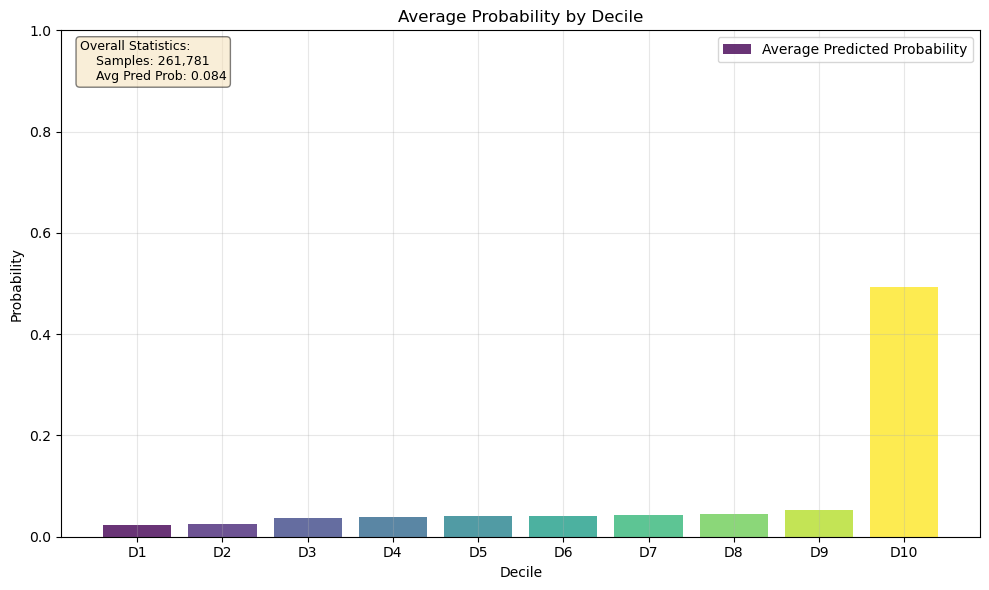

In [328]:
plot_probability_by_decile(y_prob=pi_accept)

In [339]:
mask_p_accept_region.sum()

145297

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Average Probability by Decile'}, xlabel='Decile', ylabel='Probability'>,
    decile  avg_pred_prob  min_pred_prob  max_pred_prob  count
 0       1         0.0824         0.0221         0.1048  26179
 1       2         0.1195         0.1048         0.1329  26178
 2       3         0.1447         0.1329         0.1559  26178
 3       4         0.1668         0.1559         0.1775  26178
 4       5         0.1885         0.1775         0.1997  26178
 5       6         0.2117         0.1997         0.2242  26178
 6       7         0.2381         0.2242         0.2532  26178
 7       8         0.2709         0.2532         0.2911  26178
 8       9         0.3187         0.2911         0.3533  26178
 9      10         0.4347         0.3533         0.8696  26178)

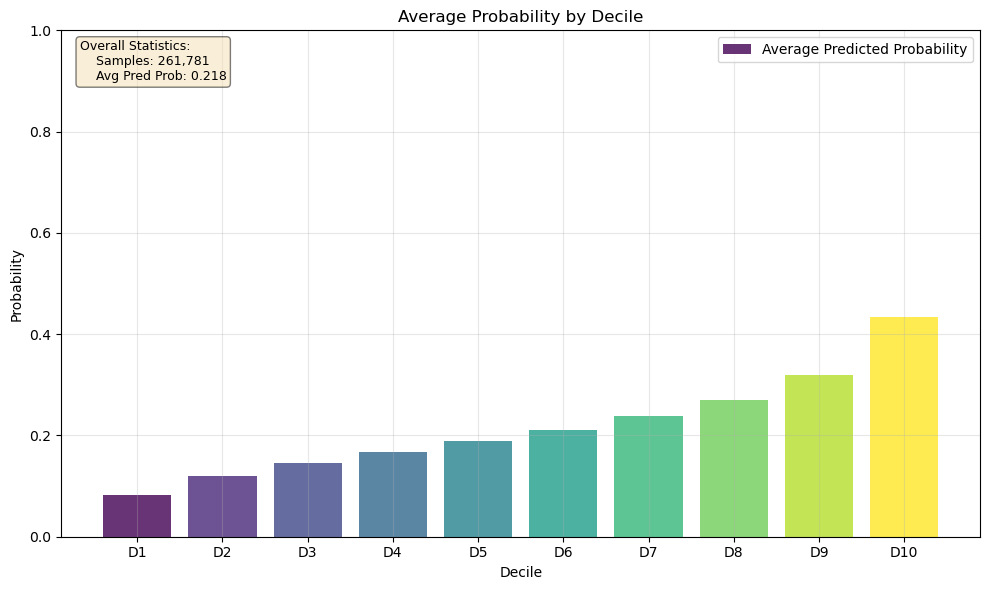

In [329]:
plot_probability_by_decile(y_prob=pd_reject)

In [343]:
roc_gap_by_decile(y_a_train,base_model_cb.predict_proba(X_a_train)[:,1],n_bins=10)

,decile,thr,n,w,bad,good,cum_bad,cum_good,TPR,FPR,GAP,bin_bad_rate
0,1,0.019059,3430,3430.0,9.0,3421.0,1597.0,32697.0,1.000000,1.000000,0.000000,0.002624
1,2,0.071643,3429,3429.0,26.0,3403.0,1588.0,29276.0,0.994364,0.895373,0.098992,0.007582
2,3,0.092451,3429,3429.0,54.0,3375.0,1562.0,25873.0,0.978084,0.791296,0.186788,0.015748
3,4,0.110447,3430,3430.0,76.0,3354.0,1508.0,22498.0,0.944271,0.688075,0.256195,0.022157
4,5,0.128705,3429,3429.0,91.0,3338.0,1432.0,19144.0,0.896681,0.585497,0.311184,0.026538
5,6,0.147320,3429,3429.0,120.0,3309.0,1341.0,15806.0,0.839699,0.483408,0.356291,0.034996
6,7,0.168790,3430,3430.0,146.0,3284.0,1221.0,12497.0,0.764559,0.382206,0.382352,0.042566
7,8,0.194405,3429,3429.0,165.0,3264.0,1075.0,9213.0,0.673137,0.281769,0.391368,0.048119
8,9,0.227777,3429,3429.0,294.0,3135.0,910.0,5949.0,0.569818,0.181943,0.387875,0.085739
9,10,0.281866,3430,3430.0,616.0,2814.0,616.0,2814.0,0.385723,0.086063,0.299660,0.179592


In [364]:
def avg_accept_by_pd_decile(pd_scores, accept_probs, n_bins=10):
    """
    Calculate average acceptance probability by PD decile.

    Parameters
    ----------
    pd_scores : array-like
        Predicted PDs (probabilities of default).
    accept_probs : array-like
        Predicted acceptance probabilities (from propensity model).
    n_bins : int, optional
        Number of deciles/bins (default=10).

    Returns
    -------
    pd.DataFrame
        DataFrame with decile, PD range, count, and average acceptance probability.
    """
    df = pd.DataFrame({
        "pd_score": pd_scores,
        "accept_prob": accept_probs
    })

    # Create deciles based on PD score
    df["pd_decile"] = pd.qcut(df["pd_score"], q=n_bins, labels=False, duplicates="drop") + 1

    # Aggregate
    result = df.groupby("pd_decile").agg(
        avg_accept_prob=("accept_prob", "mean"),
        avg_pd=("pd_score", "mean"),
        min_pd=("pd_score", "min"),
        max_pd=("pd_score", "max"),
        count=("pd_score", "size")
    ).reset_index()

    return result.sort_values("pd_decile")

In [365]:
avg_accept_by_pd_decile(pd_reject,pi_accept)

,pd_decile,avg_accept_prob,avg_pd,min_pd,max_pd,count
0,1,0.125237,0.082358,0.022085,0.104766,26179
1,2,0.105409,0.119503,0.104768,0.132904,26178
2,3,0.094118,0.144674,0.132905,0.155928,26178
3,4,0.088267,0.166818,0.155928,0.177524,26178
4,5,0.081990,0.188486,0.177526,0.199693,26178
5,6,0.078273,0.211702,0.199694,0.224196,26178
6,7,0.076167,0.238064,0.224197,0.253164,26178
7,8,0.069961,0.270917,0.253165,0.291094,26178
8,9,0.064368,0.318698,0.291095,0.353326,26178
9,10,0.053840,0.434661,0.353328,0.869632,26178


In [368]:
mask_p_accept_region = (pi_accept >= 0.0227) & (pi_accept <= 0.1220)

In [667]:
mask_pd_region = (pd_reject >= 0.353326) & (pd_reject < 1)

In [668]:
len(X_r[mask_pd_region & mask_p_accept_region])

21742

In [669]:
# budget = 13000 # ~5% reject

In [670]:
# _, X_ri, _, y_ri = train_test_split(X_r.loc[mask_pd_region & mask_p_accept_region], y_r[mask_pd_region & mask_p_accept_region], test_size=budget/len(X_r[mask_pd_region & mask_p_accept_region]), random_state=1)

In [671]:
X_ri = X_r[mask_pd_region & mask_p_accept_region]

In [672]:
y_ri = y_r[mask_pd_region & mask_p_accept_region]

In [673]:
len(y_ri)

21742

In [674]:
X_train_new = pd.concat([X_a_train,X_ri],axis=0)
y_train_new = pd.concat([y_a_train,y_ri])

In [675]:
enhanced_model_gri = CatBoostXT_BAG(
    num_bag_folds=1,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [676]:
enhanced_model_gri.params = {
    'iterations': 1000,
    'learning_rate': 0.010353843378600744,
    'depth': 4,
    'l2_leaf_reg': 89,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [677]:
enhanced_model_gri.fit(X_train_new, y_train_new, eval_set=(X_a_val, y_a_val))

In [678]:
enhanced_model_gri.evaluate(X_train_new, y_train_new)

{'ROC_AUC': 0.788117878023926, 'PR_AUC': 0.3314235161573915}

In [679]:
enhanced_model_gri.evaluate(X_a_val, y_a_val)

{'ROC_AUC': 0.7162944799308436, 'PR_AUC': 0.13899822429047232}

In [680]:
enhanced_model_gri.evaluate(X_all_val, y_all_val)

{'ROC_AUC': 0.6987367955167795, 'PR_AUC': 0.20155322450126828}

In [681]:
tail_precision(enhanced_model_gri.predict_proba(X_all_val)[:,1],y_all_val,mode='percentile',hi=0.8,lo=0.2)

(0.17605359001040582,
 0.9719693028095734,
 15376,
 15376,
 0.2505109207363053,
 0.0940903909980587)

#### Baseline model performance

In [413]:
base_model_cb.evaluate(X_a_val, y_a_val)

{'ROC_AUC': 0.7136296363569091, 'PR_AUC': 0.1251414665267777}

In [259]:
base_model_cb.evaluate(X_all_val, y_all_val)

{'ROC_AUC': 0.6931296713741353, 'PR_AUC': 0.17903990758155733}

In [497]:
tail_precision(base_model_cb.predict_proba(X_a_val)[:,1],y_a_val,mode='percentile',hi=0.8,lo=0.2)

(0.11145104895104894,
 0.9903846153846154,
 2288,
 2288,
 0.22652274781818119,
 0.09203151485681844)

In [498]:
tail_precision(base_model_cb.predict_proba(X_all_val)[:,1],y_all_val,mode='percentile',hi=0.8,lo=0.2)

(0.1702653485952133,
 0.9723595213319459,
 15376,
 15376,
 0.2825922336641325,
 0.12476446800685552)

#### Oracle model

In [496]:
# load pickle
with open(rf'{data_dir}\models\oracle_model_catboostxt_bag.pkl', 'rb') as f:
    oracle_model = pickle.load(f)

In [499]:
oracle_model.evaluate(X_a_val, y_a_val)

{'ROC_AUC': 0.7456136456136456, 'PR_AUC': 0.16302549376195397}

In [500]:
oracle_model.evaluate(X_all_val, y_all_val)

{'ROC_AUC': 0.7445511647641232, 'PR_AUC': 0.22695016304073454}

In [501]:
tail_precision(oracle_model.predict_proba(X_a_val)[:,1],y_a_val,mode='percentile',hi=0.8,lo=0.2)

(0.12194055944055944,
 0.9916958041958042,
 2288,
 2288,
 0.2446898378615201,
 0.08228949907477823)

In [502]:
tail_precision(oracle_model.predict_proba(X_all_val)[:,1],y_all_val,mode='percentile',hi=0.8,lo=0.2)

(0.2005723204994797,
 0.9819198751300728,
 15376,
 15376,
 0.2996924301329079,
 0.09999442488670045)

In [ ]:
0.7192928283837375

In [ ]:
uncertain 0.5
0.7171362307725945
0.7088962237096864

In [ ]:
uncertain: 0.6
0.7189187916460644
0.7019713941228887

In [281]:
uncertain: 0.3
0.7158228976410794
0.701965475161118

0.701965475161118

In [682]:
# ---- Random selection ----
random_indices = random_select(
    pi_reject=pi_accept,
    budget=20000,
    range=(0.01,0.99),
    random_state=42
)

In [683]:
# Random reject inference data
X_inference_rnd = X_r.iloc[random_indices]
y_inference_rnd = y_r[random_indices]

In [684]:
X_train_new_rnd = pd.concat([X_a_train,X_inference_rnd],axis=0)
y_train_new_rnd = pd.concat([y_a_train,y_inference_rnd])

In [685]:
enhanced_model_gri_rnd = CatBoostXT_BAG(
    num_bag_folds=1,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [686]:
enhanced_model_gri_rnd.params = {
    'iterations': 1000,
    'learning_rate': 0.010353843378600744,
    'depth': 4,
    'l2_leaf_reg': 89,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [687]:
enhanced_model_gri_rnd.fit(X_train_new_rnd, y_train_new_rnd, eval_set=(X_a_val, y_a_val))

In [688]:
enhanced_model_gri_rnd.evaluate(X_train_new_rnd, y_train_new_rnd)

{'ROC_AUC': 0.7735347623323996, 'PR_AUC': 0.19456133111830093}

In [689]:
enhanced_model_gri_rnd.evaluate(X_a_val, y_a_val)

{'ROC_AUC': 0.7107787835060563, 'PR_AUC': 0.12605093109626242}

In [690]:
enhanced_model_gri_rnd.evaluate(X_all_val, y_all_val)

{'ROC_AUC': 0.693549842418815, 'PR_AUC': 0.17918621045773228}

In [691]:
tail_precision(enhanced_model_gri_rnd.predict_proba(X_all_val)[:,1],y_all_val,mode='percentile',hi=0.8,lo=0.2)

(0.17117585848074923,
 0.9720993756503642,
 15376,
 15376,
 0.2831559993611583,
 0.12383641452564766)